# Clustering to Identify Physiological Response Patterns

## Aim / Research Question:
Can we identify distinct physiological response profiles (clusters) across individuals and phases that correspond to different emotional states (stress, rest, recovery)?

## Import libraries

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## Loading data

In [3]:
data_path = '../data/HR_data.csv'
data = pd.read_csv(data_path)

# Saving the column names
columns = data.columns.tolist()

# Print the first few rows of the dataset
#print(data.head())

# Printing the shape of the dataset
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

# Checking for missing values (True/False)
print("Does the dataset have missing values?", data.isnull().values.any())

The dataset has 312 rows and 68 columns.
Does the dataset have missing values? True


## Data Wrangling

### Handling missing values

In [4]:
# Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
data = categorical_imputer.fit_transform(data)

# Converting the imputed data back to a DataFrame
data = pd.DataFrame(data, columns=columns)

### Moving Columns Around

In [5]:
# Move Unnamed: 0,Round,Phase,Individual,Puzzler,Cohort to the front of the DataFrame
data = data[['Unnamed: 0', 'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort'] + [col for col in data.columns if col not in ['Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']]]

In [6]:
print(data)

    Unnamed: 0    Round   Phase Individual Puzzler Cohort Unnamed: 0  \
0            0  round_3  phase3          1       1   D1_4          0   
1            1  round_3  phase2          1       1   D1_4          1   
2            2  round_3  phase1          1       1   D1_4          2   
3            3  round_2  phase3          1       1   D1_4          3   
4            4  round_2  phase2          1       1   D1_4          4   
..         ...      ...     ...        ...     ...    ...        ...   
307        307  round_4  phase2         26       1   D1_5        307   
308        308  round_4  phase1         26       1   D1_5        308   
309        309  round_1  phase3         26       1   D1_5        309   
310        310  round_1  phase2         26       1   D1_5        310   
311        311  round_1  phase1         26       1   D1_5        311   

     HR_TD_Mean HR_TD_Median  HR_TD_std  ... upset hostile alert ashamed  \
0     78.663878         76.7   7.480043  ...   1.0     1.0 

### Splitting the Data Into Self-Rated Questionaire and Bio-Signals

In [7]:
# Self-Rated Questionaire
self_rated = data.iloc[:, -11:]

# Bio-Signals
bio_signals = data.iloc[:, :-11]
# Only keep the columns that starts with 'HR', 'TEMP', or 'EDA'
bio_signals = bio_signals.loc[:, bio_signals.columns.str.startswith(('HR', 'TEMP', 'EDA'))]

# All features
X_all = pd.concat([self_rated, bio_signals], axis=1)

### Normalizing

In [8]:
# Normalizing the Bio-Signals using StandardScaler
scaler = StandardScaler()
bio_signals_scaled = scaler.fit_transform(bio_signals)

# Normalizing the Self-Rated Questionnaire using StandardScaler
self_rated_scaled = scaler.fit_transform(self_rated)

# Normalizing the all features using StandardScaler
X_all_scaled = scaler.fit_transform(X_all)

# K-Means Clustering

### Elbow Plot

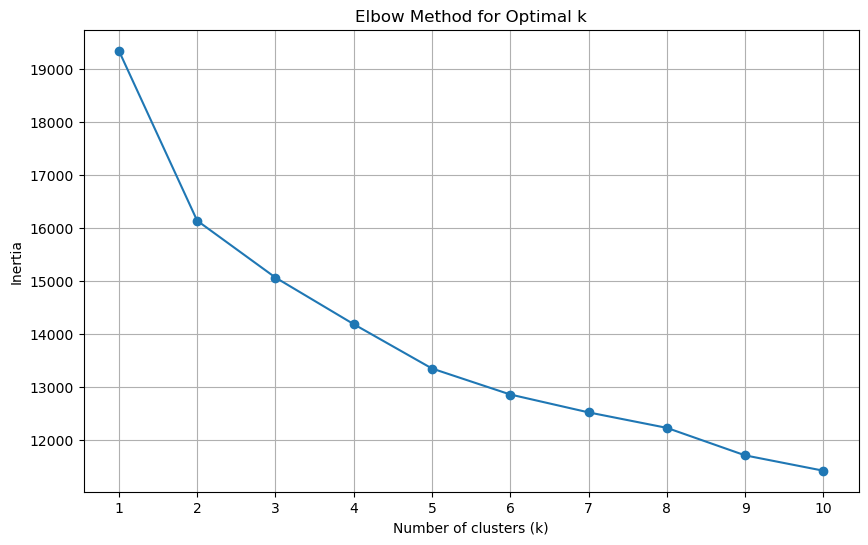

In [9]:
# Using the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_all_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()


### Performing K-Means

In [14]:
# Performing KMeans clustering with the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_all_scaled)

# Adding the cluster labels to the original data
data['Cluster'] = kmeans.labels_


# Principal Component Analysis (PCA)

## PCA Using All Features + K-Means

### Computing Principal Components

In [15]:
# Performing PCA for visualization
pca = PCA()
X_pca = pca.fit_transform(X_all_scaled)

### Explained Variance

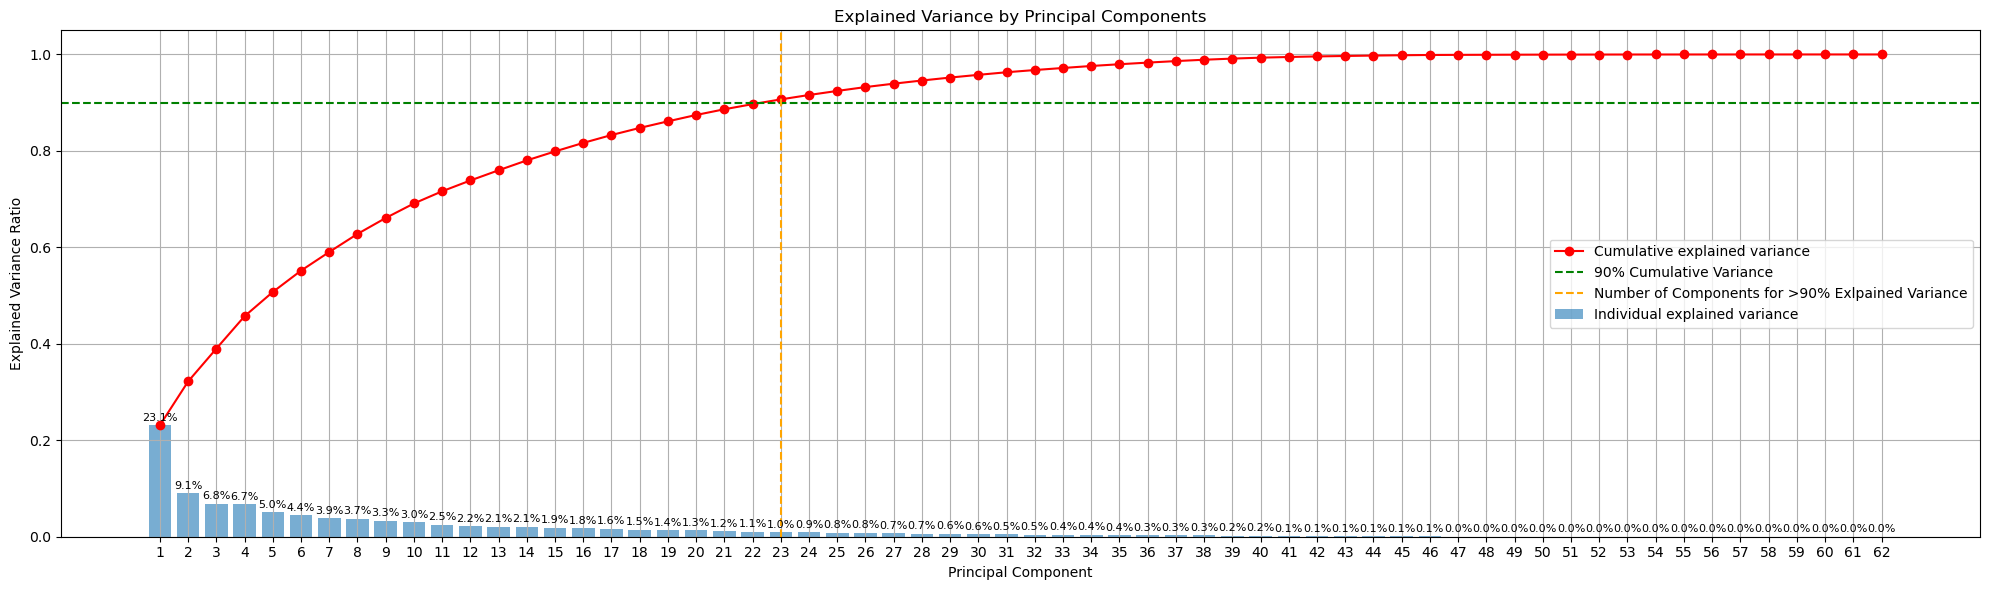

In [16]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(20, 6))

# Bar plot of individual explained variance
bars = plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label='Individual explained variance')

# Line plot of cumulative explained variance
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative explained variance')

# Add percentage labels on top of bars
for i, ev in enumerate(explained_variance):
    plt.text(i + 1, ev + 0.005, f"{ev * 100:.1f}%", ha='center', va='bottom', fontsize=8)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance)+1))
# Plot a line for 90% cumulative variance
plt.axhline(y=0.9, color='green', linestyle='--', label='90% Cumulative Variance')
# Plot a vertical line for the number of components needed to reach 90% cumulative variance
plt.axvline(x=np.argmax(cumulative_variance >= 0.9) + 1, color='orange', linestyle='--', label='Number of Components for >90% Exlpained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting

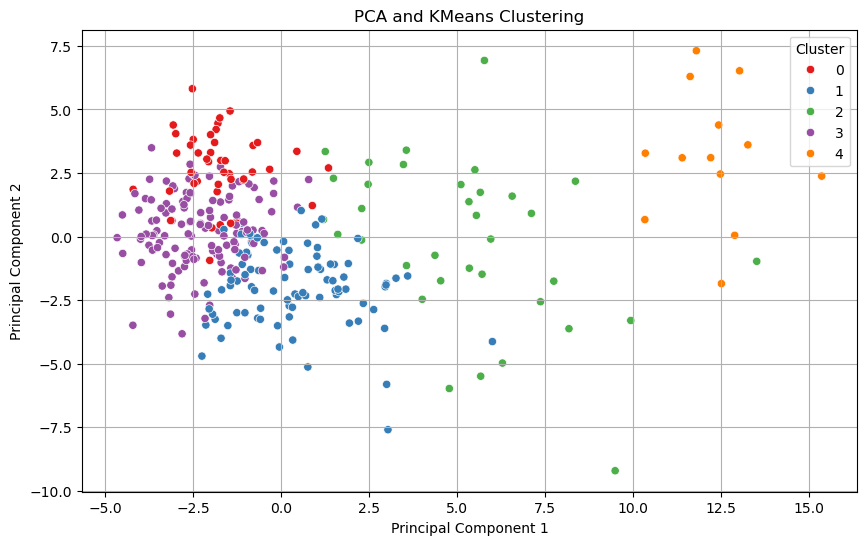

In [20]:
# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Adding the cluster labels to the PCA DataFrame
pca_df['Cluster'] = data['Cluster']

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title('PCA and KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

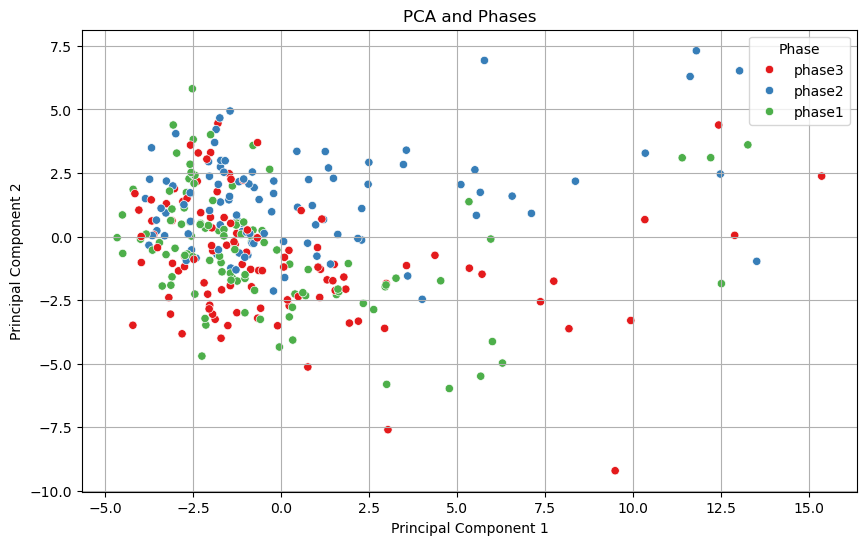

In [ ]:
# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Adding the Phase labels to the PCA DataFrame
pca_df['Phase'] = data['Phase'].values

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Phase', palette='Set1')
plt.title('PCA and Phases')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Phase')
plt.grid()
plt.show()

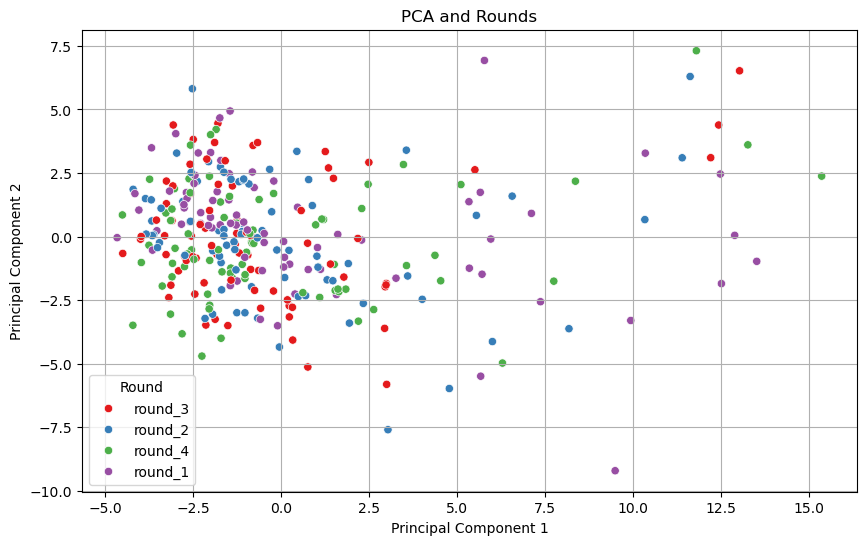

In [24]:
# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Adding the Round labels to the PCA DataFrame
pca_df['Round'] = data['Round'].values

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Round', palette='Set1')
plt.title('PCA and Rounds')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Round')
plt.grid()
plt.show()

In [26]:
print(data['Cohort'].unique())

['D1_4' 'D1_6' 'D1_1' 'D1_2' 'D1_3' 'D1_5']


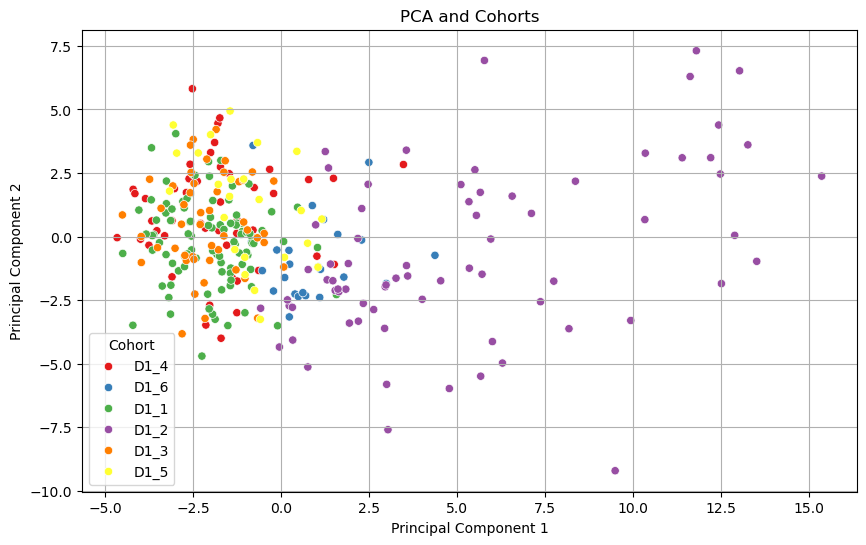

In [25]:
# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Adding the Cohort labels to the PCA DataFrame
pca_df['Cohort'] = data['Cohort'].values

# Plotting the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cohort', palette='Set1')
plt.title('PCA and Cohorts')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cohort')
plt.grid()
plt.show()

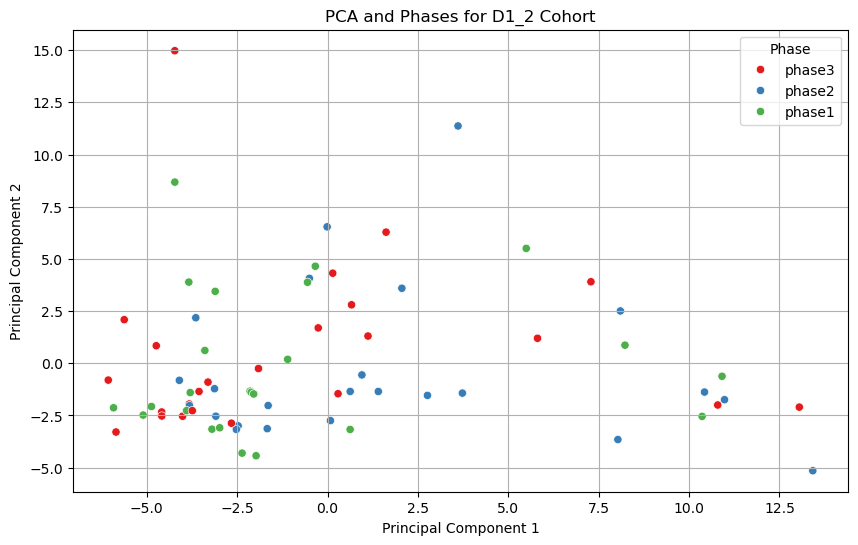

In [31]:
# Extracting Cohort D1_2 from X_all
X_cohort_d1_2 = X_all_scaled[data['Cohort'] == 'D1_2']

# Performing PCA on the D1_2 cohort
pca_d1_2 = PCA()
X_pca_d1_2 = pca_d1_2.fit_transform(X_cohort_d1_2)

# Adding the Phase labels to the PCA DataFrame
pca_df_d1_2 = pd.DataFrame(data=X_pca_d1_2, columns=[f'PC{i+1}' for i in range(X_pca_d1_2.shape[1])])
pca_df_d1_2['Phase'] = data['Phase'].values[data['Cohort'] == 'D1_2']
# Plotting the PCA results for D1_2 cohort
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_d1_2, x='PC1', y='PC2', hue='Phase', palette='Set1')
plt.title('PCA and Phases for D1_2 Cohort')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Phase')
plt.grid()
plt.show()

## PCA Using Only Bio-Signals

### Computing Principal Components

In [32]:
# Fit PCA to standardized data
pca = PCA()
bio_signals_pca = pca.fit_transform(bio_signals_scaled)

### Explained Variance

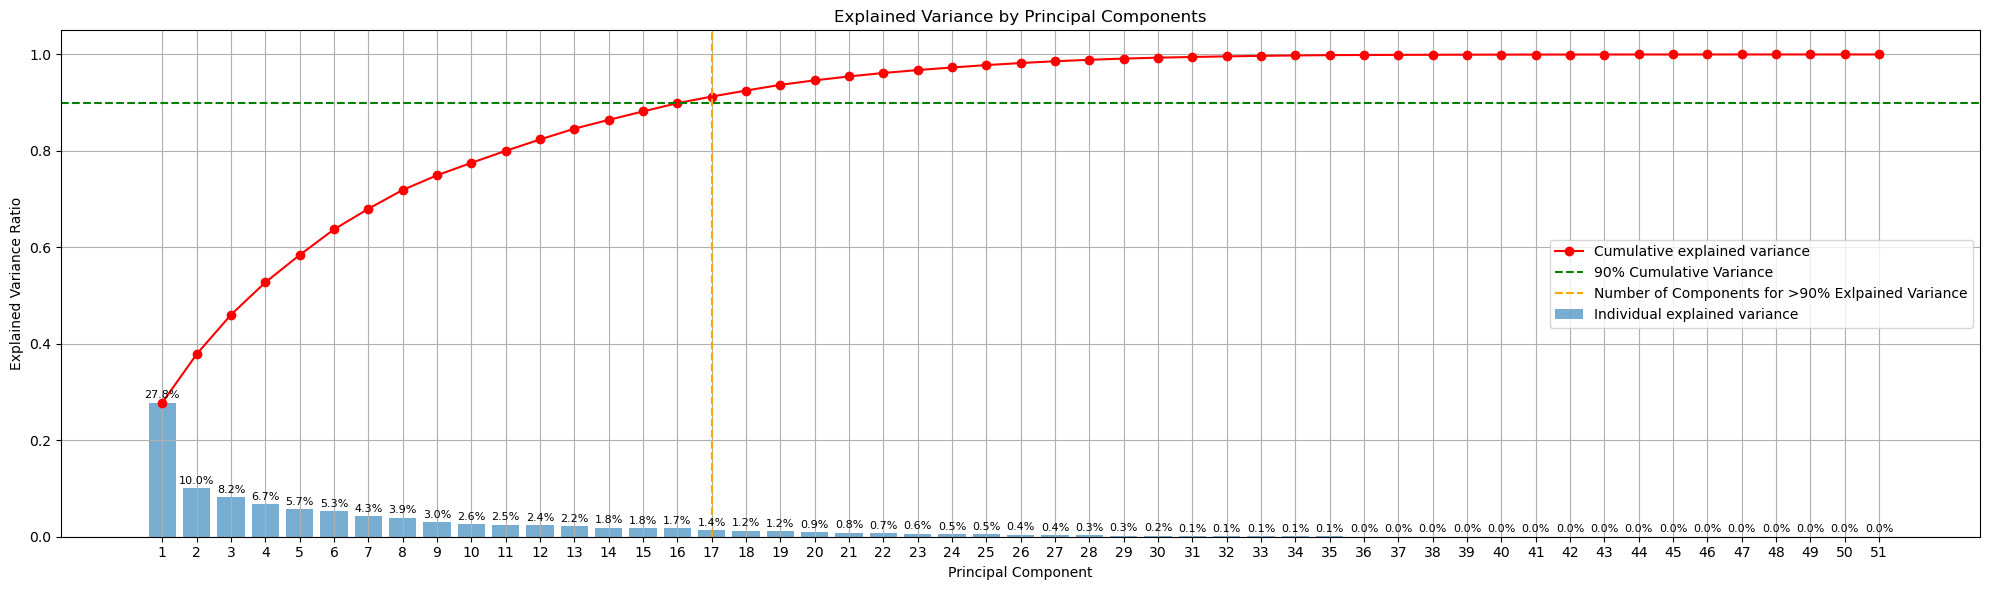

In [ ]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(20, 6))

# Bar plot of individual explained variance
bars = plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label='Individual explained variance')

# Line plot of cumulative explained variance
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative explained variance')

# Add percentage labels on top of bars
for i, ev in enumerate(explained_variance):
    plt.text(i + 1, ev + 0.005, f"{ev * 100:.1f}%", ha='center', va='bottom', fontsize=8)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance)+1))
# Plot a line for 90% cumulative variance
plt.axhline(y=0.9, color='green', linestyle='--', label='90% Cumulative Variance')
# Plot a vertical line for the number of components needed to reach 90% cumulative variance
plt.axvline(x=np.argmax(cumulative_variance >= 0.9) + 1, color='orange', linestyle='--', label='Number of Components for >90% Exlpained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting

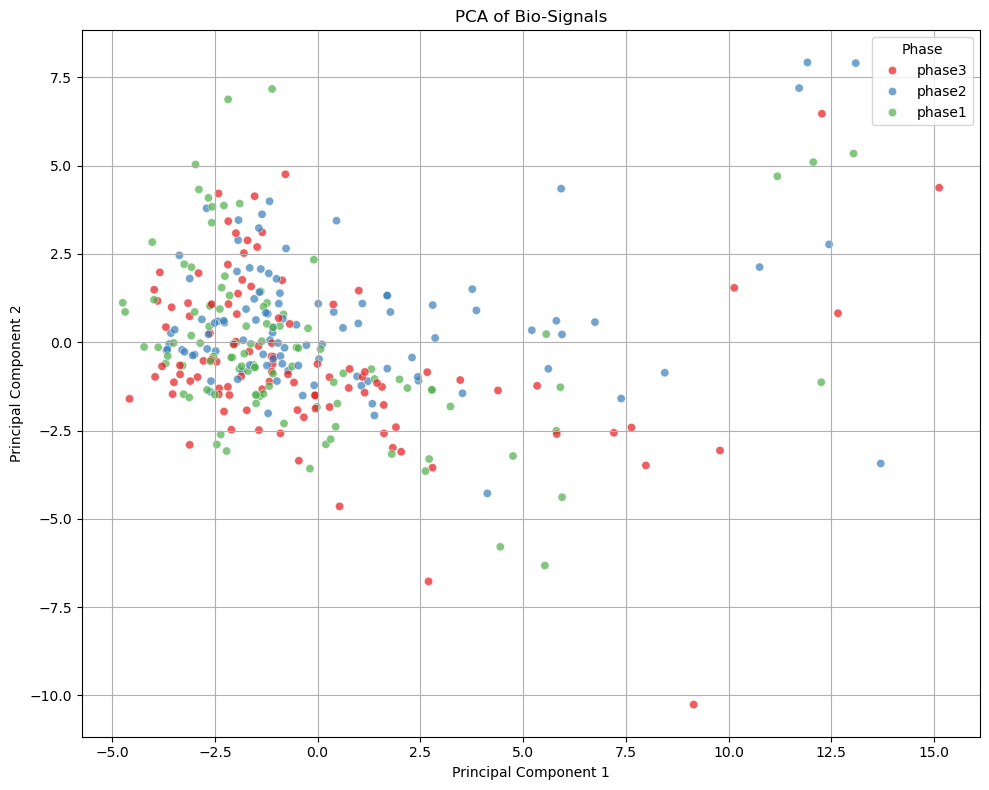

In [ ]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(bio_signals_pca.shape[1])]
df_pca = pd.DataFrame(bio_signals_pca, columns=pc_cols)
df_pca['Phase'] = data['Phase'].values

# Plotting the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Phase', palette='Set1', alpha=0.7)
plt.title('PCA of Bio-Signals')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Phase')
plt.tight_layout()
plt.show()

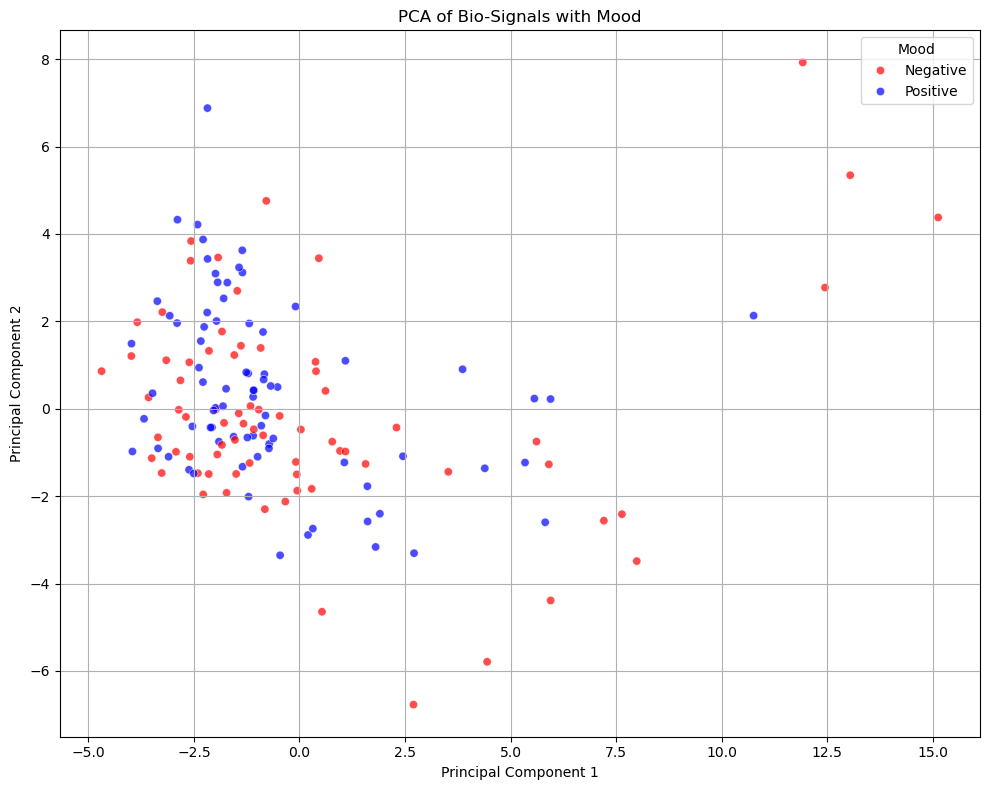

In [ ]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(bio_signals_pca.shape[1])]
df_pca = pd.DataFrame(bio_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the positive and negative self-rated questionnaire
positive_mean = np.mean(positive_scaled, axis=1)
negative_mean = np.mean(negative_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Positive'] = positive_mean
df_pca['Negative'] = negative_mean

# Make a dataframe of top 50% of positive and negative self-rated questionnaire
df_pca['Positive'] = np.where(df_pca['Positive'] > df_pca['Positive'].median(), 1, 0)
df_pca['Negative'] = np.where(df_pca['Negative'] > df_pca['Negative'].median(), 1, 0)

# Remove rows where Positive and Negative are both 0 or 1
df_pca = df_pca[~((df_pca['Positive'] == 0) & (df_pca['Negative'] == 0)) & ~((df_pca['Positive'] == 1) & (df_pca['Negative'] == 1))]

# Combine the Positive and Negative columns into a single column where 1 = Positive, -1 = Negative
df_pca['Mood'] = np.where(df_pca['Positive'] == 1, 'Positive', 'Negative')

# Plotting the PCA results with Mood
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Mood', palette={'Positive': 'blue', 'Negative': 'red'}, alpha=0.7)
plt.title('PCA of Bio-Signals with Mood')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Mood')
plt.tight_layout()
plt.show()

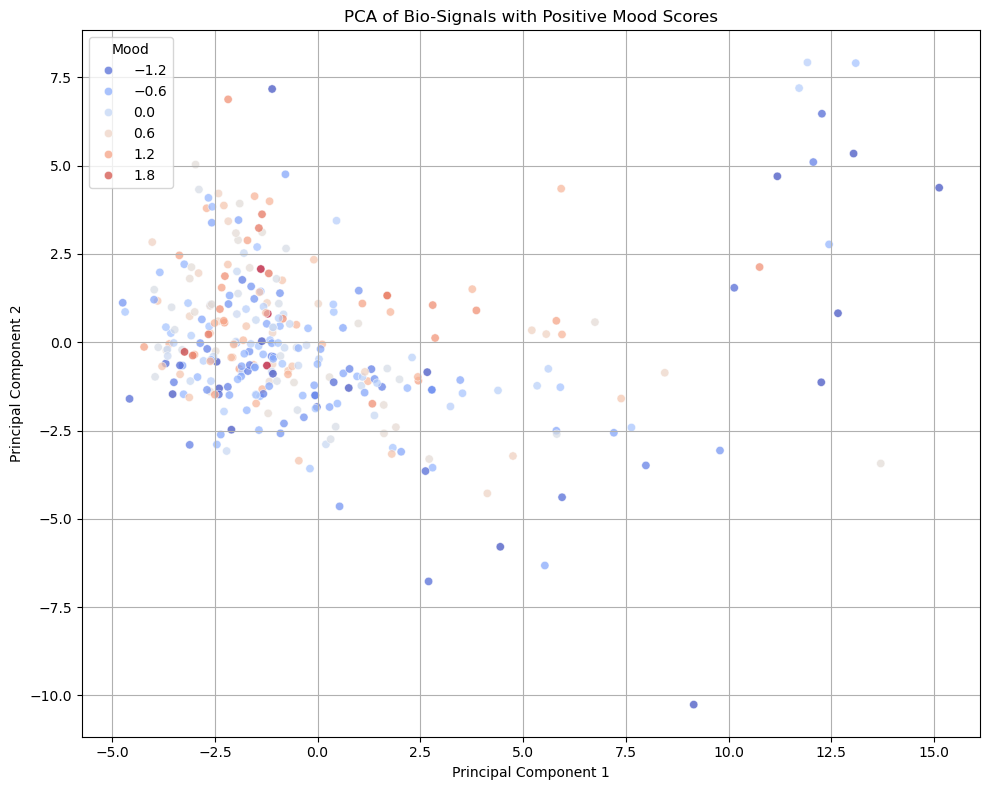

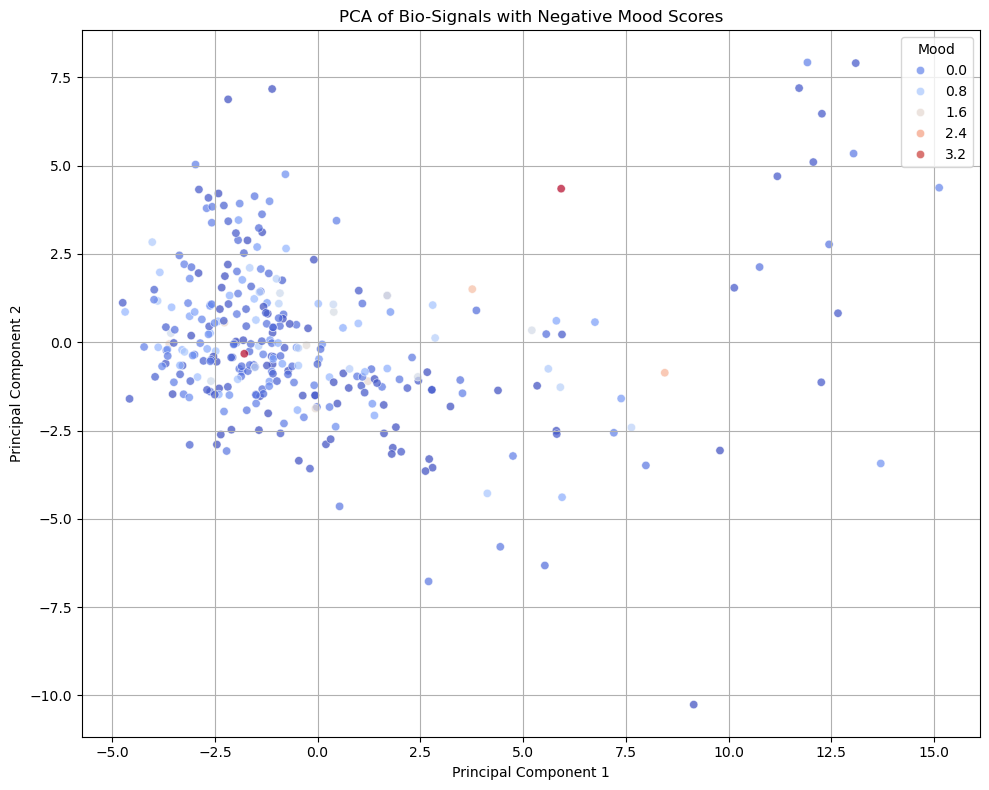

In [46]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(bio_signals_pca.shape[1])]
df_pca = pd.DataFrame(bio_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the positive and negative self-rated questionnaire
positive_mean = np.mean(positive_scaled, axis=1)
negative_mean = np.mean(negative_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Positive'] = positive_mean
df_pca['Negative'] = negative_mean

# Plotting the PCA results with Positive scores as continuous variable
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Positive', palette='coolwarm', alpha=0.7)
plt.title('PCA of Bio-Signals with Positive Mood Scores')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Mood')
plt.tight_layout()
plt.show()

# Plotting the PCA results with Negative scores as continuous variable
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Negative', palette='coolwarm', alpha=0.7)
plt.title('PCA of Bio-Signals with Negative Mood Scores')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Mood')
plt.tight_layout()
plt.show()

## PCA Using Only Emo-Signals

### Computing Principal Components

In [65]:
# Fit PCA to standardized data
pca = PCA()
emo_signals_pca = pca.fit_transform(self_rated_scaled)

### K-Means

In [71]:
# Running k-means clustering on the PCA results
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(emo_signals_pca)
# Adding the cluster labels to the PCA DataFrame
df_pca['Cluster'] = kmeans.labels_

### Explained Variance

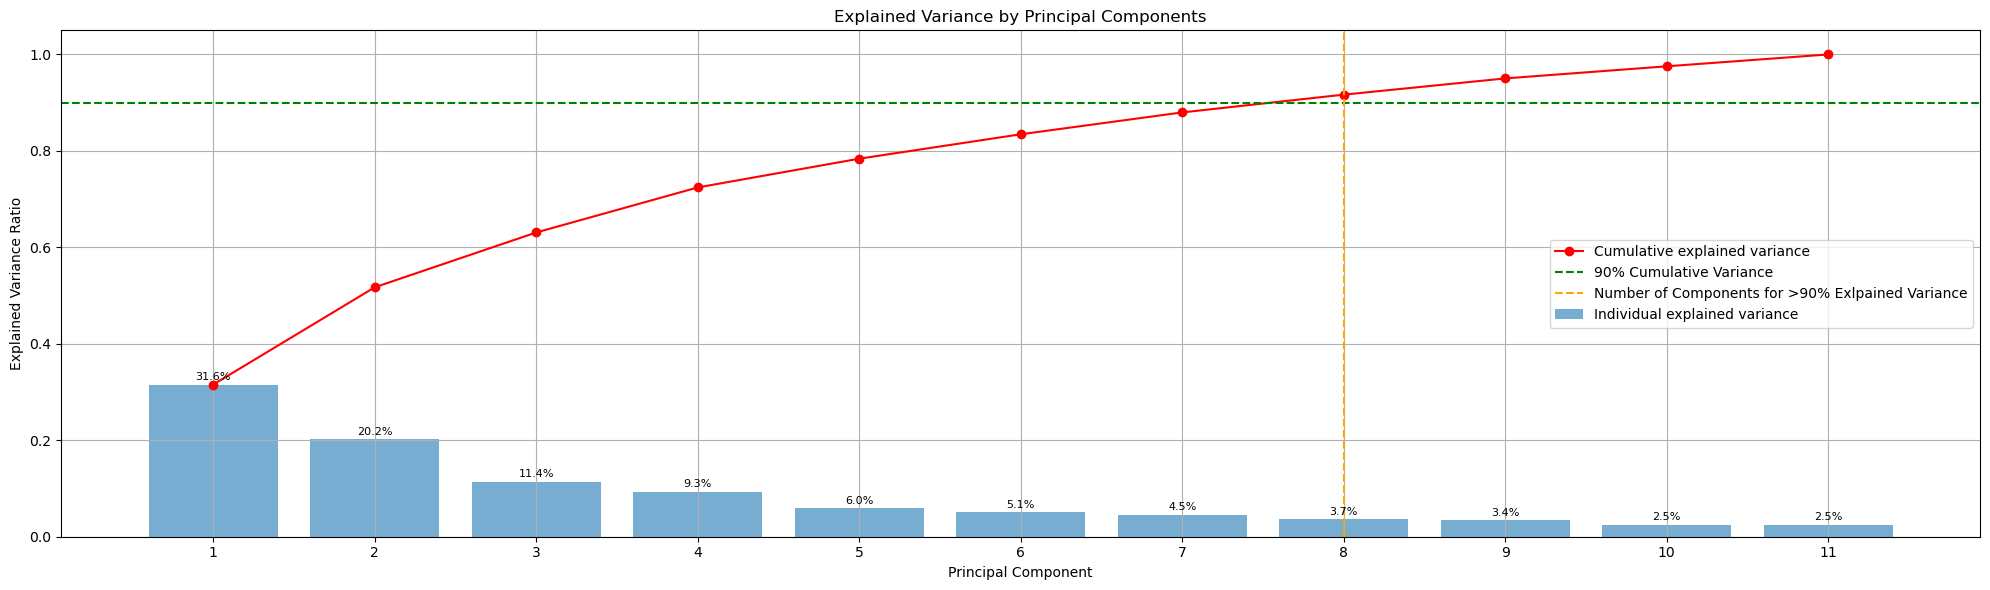

In [67]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(20, 6))

# Bar plot of individual explained variance
bars = plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label='Individual explained variance')

# Line plot of cumulative explained variance
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative explained variance')

# Add percentage labels on top of bars
for i, ev in enumerate(explained_variance):
    plt.text(i + 1, ev + 0.005, f"{ev * 100:.1f}%", ha='center', va='bottom', fontsize=8)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance)+1))
# Plot a line for 90% cumulative variance
plt.axhline(y=0.9, color='green', linestyle='--', label='90% Cumulative Variance')
# Plot a vertical line for the number of components needed to reach 90% cumulative variance
plt.axvline(x=np.argmax(cumulative_variance >= 0.9) + 1, color='orange', linestyle='--', label='Number of Components for >90% Exlpained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting

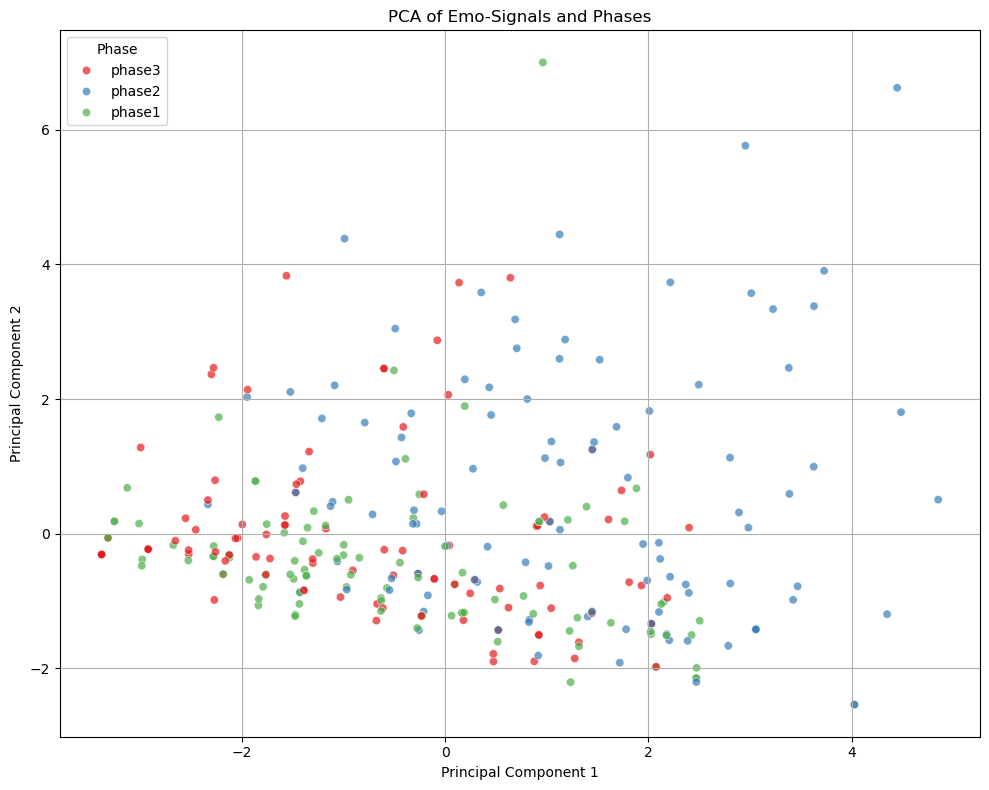

In [68]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)
df_pca['Phase'] = data['Phase'].values

# Plotting the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Phase', palette='Set1', alpha=0.7)
plt.title('PCA of Emo-Signals and Phases')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Phase')
plt.tight_layout()
plt.show()

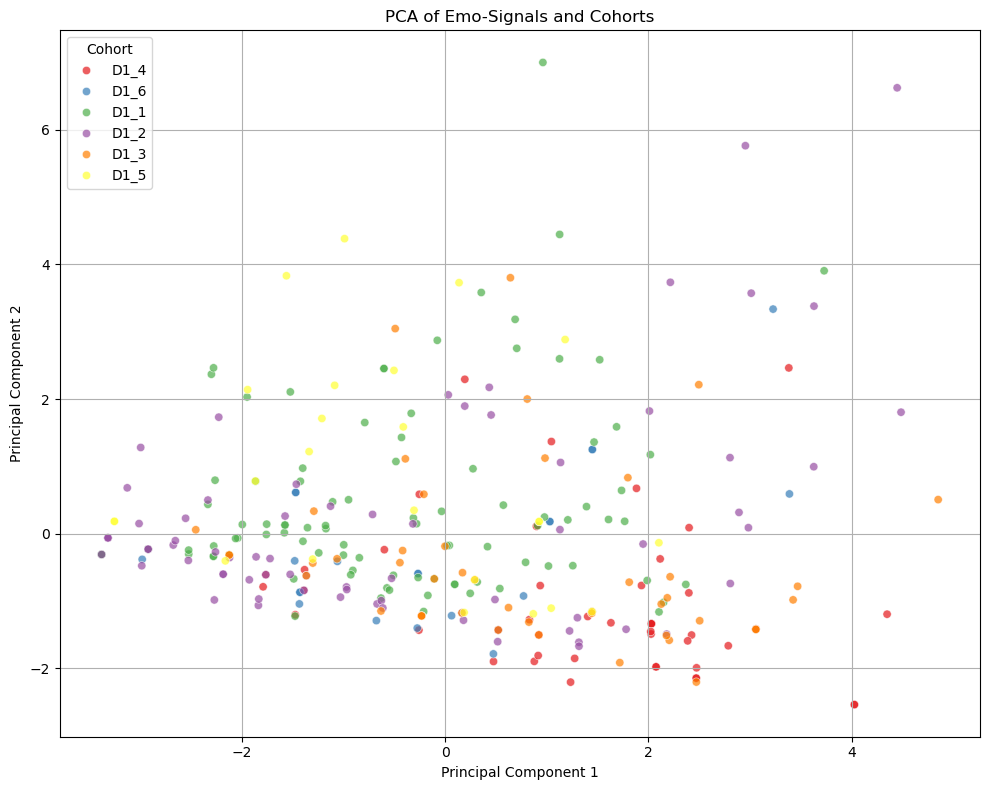

In [69]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)
df_pca['Cohort'] = data['Cohort'].values

# Plotting the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cohort', palette='Set1', alpha=0.7)
plt.title('PCA of Emo-Signals and Cohorts')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cohort')
plt.tight_layout()
plt.show()

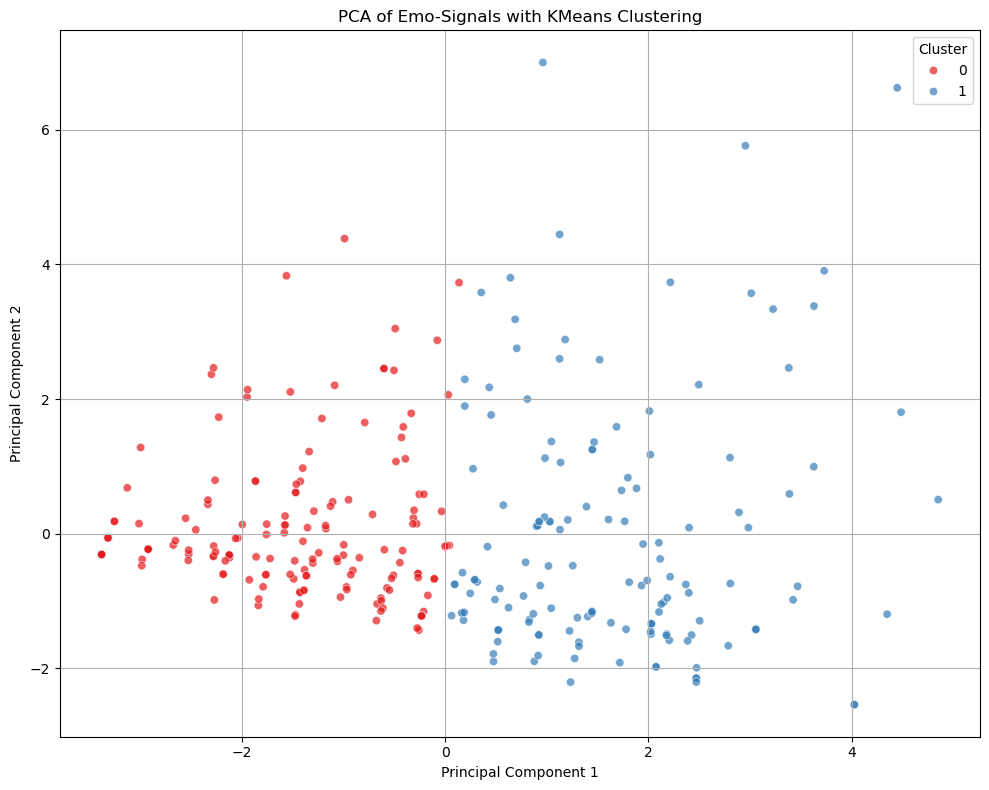

In [72]:
# Plotting KMeans clustering results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA of Emo-Signals with KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

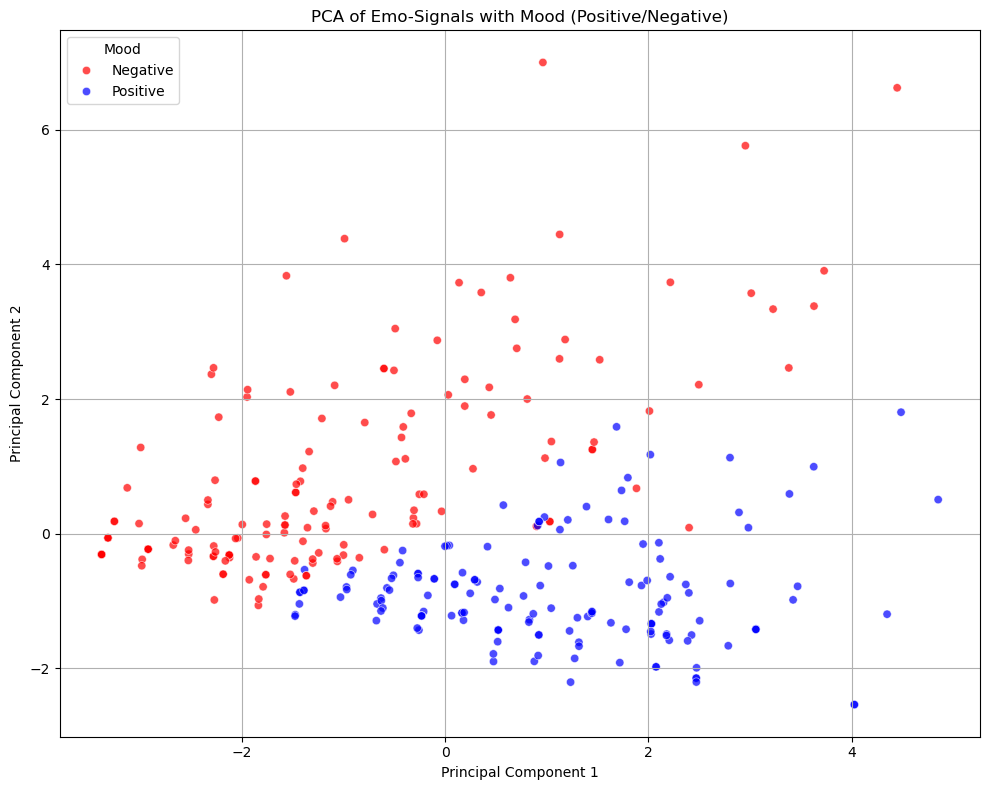

In [59]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the positive and negative self-rated questionnaire
positive_mean = np.mean(positive_scaled, axis=1)
negative_mean = np.mean(negative_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Positive'] = positive_mean
df_pca['Negative'] = negative_mean

#print(df_pca)

# Make a dataframe of top 50% of positive and negative self-rated questionnaire
df_pca['Positive'] = np.where(df_pca['Positive'] > df_pca['Negative'], 1, 0) # if greater than median, 1 else 0 
#df_pca['Negative'] = np.where(df_pca['Negative'] > df_pca['Positive'](), 1, 0) # if greater than median, 1 else 0

# Remove rows where Positive and Negative are both 0 or both 1
df_pca = df_pca[~((df_pca['Positive'] == 0) & (df_pca['Negative'] == 0)) & ~((df_pca['Positive'] == 1) & (df_pca['Negative'] == 1))]

# Combine the Positive and Negative columns into a single column where 1 = Positive, -1 = Negative
df_pca['Mood'] = np.where(df_pca['Positive'] == 1, 'Positive', 'Negative') # if positive = 1, then mood = positive else negative

# Plotting the PCA results with Mood
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Mood', palette={'Positive': 'blue', 'Negative': 'red'}, alpha=0.7)
plt.title('PCA of Emo-Signals with Mood (Positive/Negative)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Mood')
plt.tight_layout()
plt.show()

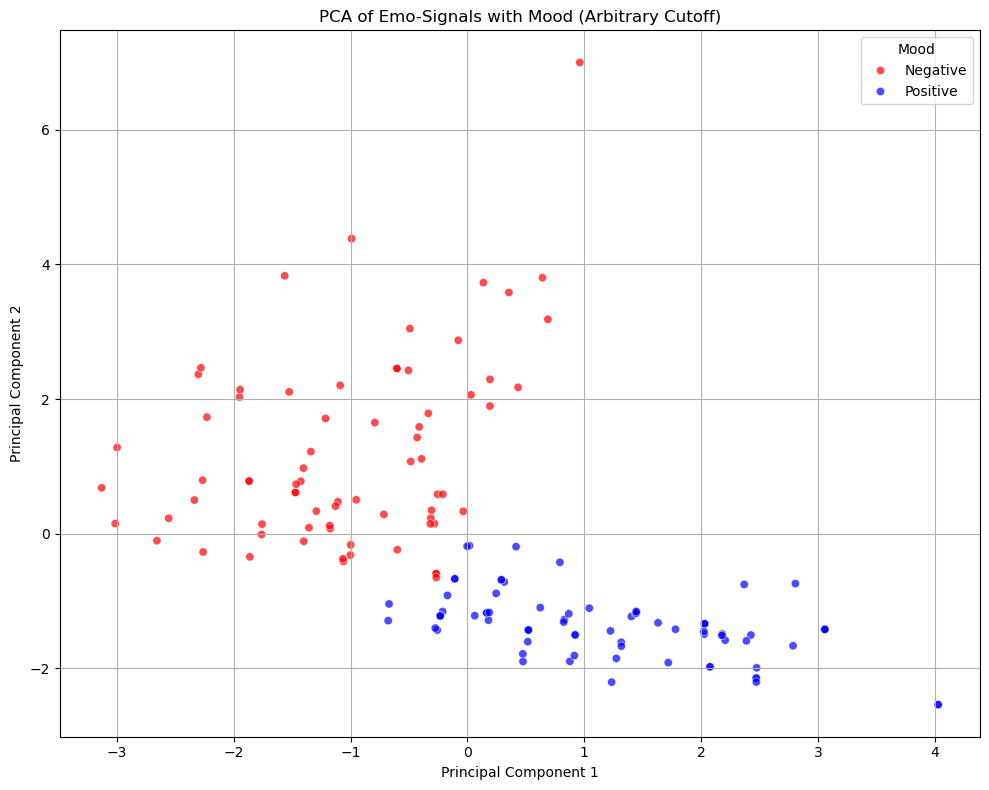

In [56]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the positive and negative self-rated questionnaire
positive_mean = np.mean(positive_scaled, axis=1)
negative_mean = np.mean(negative_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Positive'] = positive_mean
df_pca['Negative'] = negative_mean

#print(df_pca)

# Make a dataframe of top 50% of positive and negative self-rated questionnaire
df_pca['Positive'] = np.where(df_pca['Positive'] > df_pca['Positive'].median(), 1, 0) # if greater than median, 1 else 0 
df_pca['Negative'] = np.where(df_pca['Negative'] > df_pca['Negative'].median(), 1, 0) # if greater than median, 1 else 0

# Remove rows where Positive and Negative are both 0 or both 1
df_pca = df_pca[~((df_pca['Positive'] == 0) & (df_pca['Negative'] == 0)) & ~((df_pca['Positive'] == 1) & (df_pca['Negative'] == 1))]

# Combine the Positive and Negative columns into a single column where 1 = Positive, -1 = Negative
df_pca['Mood'] = np.where(df_pca['Positive'] == 1, 'Positive', 'Negative') # if positive = 1, then mood = positive else negative

# Plotting the PCA results with Mood
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Mood', palette={'Positive': 'blue', 'Negative': 'red'}, alpha=0.7)
plt.title('PCA of Emo-Signals with Mood (Arbitrary Cutoff)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Mood')
plt.tight_layout()
plt.show()

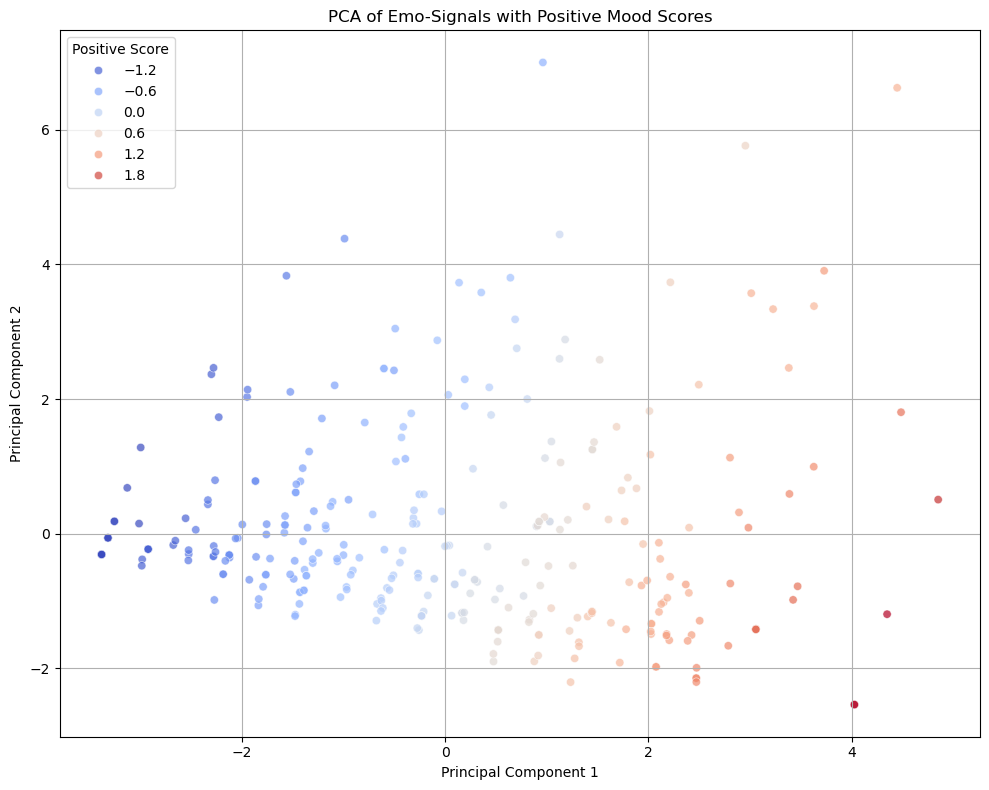

In [41]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the positive self-rated questionnaire
positive_mean = np.mean(positive_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Positive'] = positive_mean

# Plotting the PCA results with Positive scores as a continuous variable
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Positive', palette='coolwarm', alpha=0.7)
plt.title('PCA of Emo-Signals with Positive Mood Scores')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Positive Score')
plt.tight_layout()
plt.show()

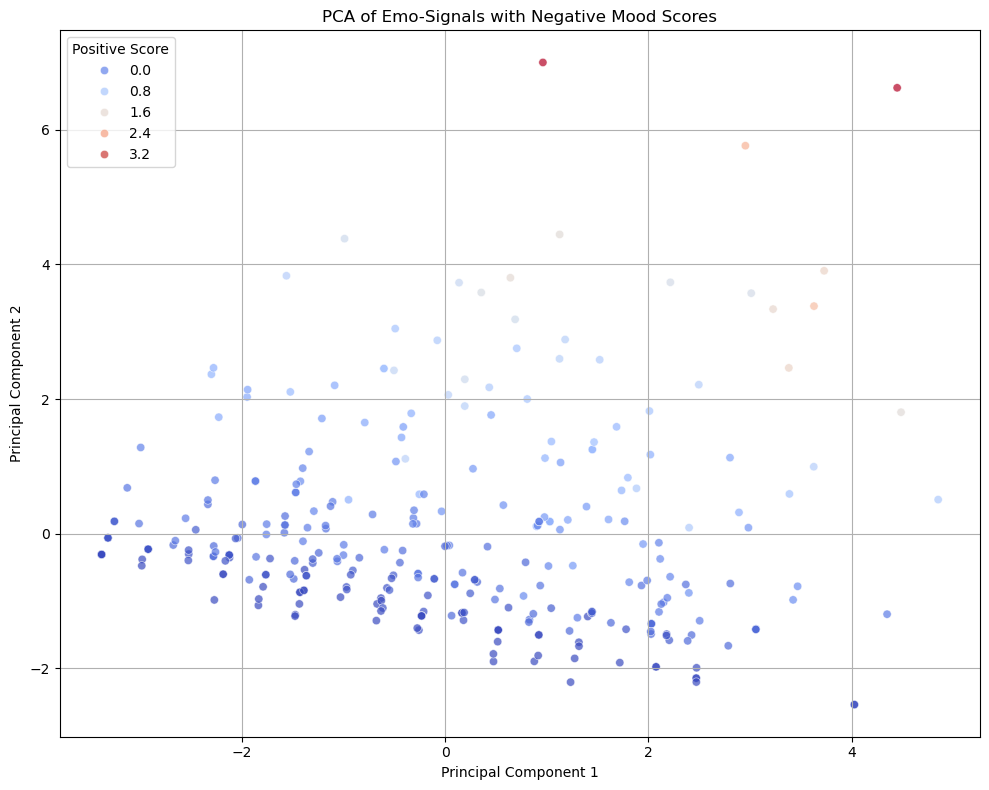

In [42]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined into positive and negative
positive = self_rated[['inspired', 'attentive', 'determined','active','alert']]
negative = self_rated[['Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']]

# Normalizing the Self-Rated Questionnaire using StandardScaler
scaler = StandardScaler()
positive_scaled = scaler.fit_transform(positive)
negative_scaled = scaler.fit_transform(negative)

# Calculating the mean of the negative self-rated questionnaire
negative_mean = np.mean(negative_scaled, axis=1)

# Adding the mean values to the PCA DataFrame
df_pca['Negative'] = negative_mean

# Plotting the PCA results with Negative scores as a continuous variable
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Negative', palette='coolwarm', alpha=0.7)
plt.title('PCA of Emo-Signals with Negative Mood Scores')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Positive Score')
plt.tight_layout()
plt.show()

# Test

Explained variance: 0.32
KMeans → Silhouette: 0.15, DBI: 2.11
GMM → Silhouette: 0.15, DBI: 2.12


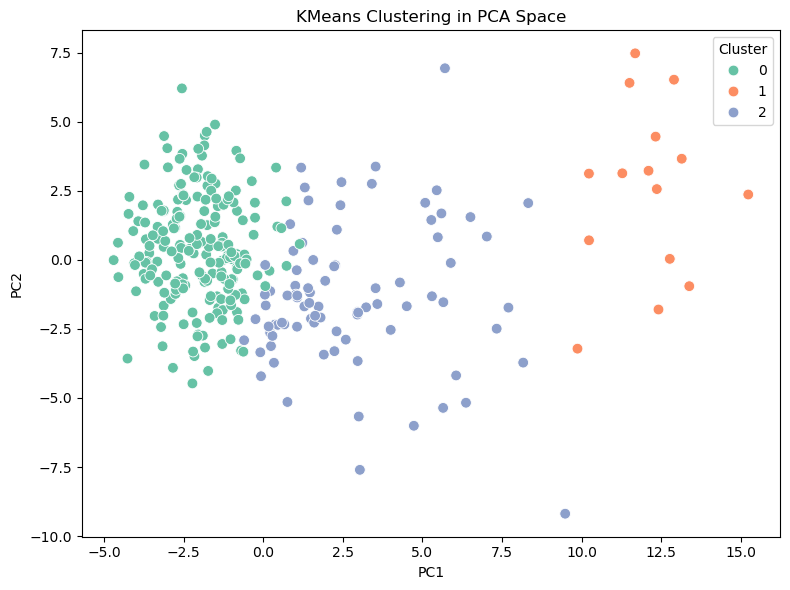

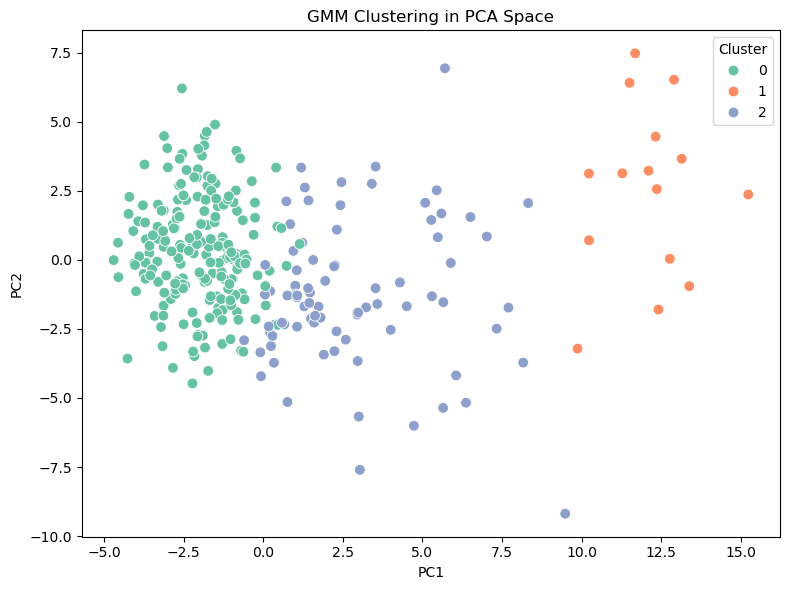

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
data_path = '../data/HR_data.csv'
df = pd.read_csv(data_path)

# Optional: drop non-feature columns (e.g. participant ID, phase, labels)
meta_cols = ['Unnamed: 0', 'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']  # adjust as needed
feature_cols = [col for col in df.columns if col not in meta_cols]
X = df[feature_cols].dropna()

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Dimensionality Reduction (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2f}")

# Step 4: Clustering - KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Step 5: Clustering - Gaussian Mixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Step 6: Evaluation
def evaluate_clustering(X, labels, name):
    silhouette = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    print(f"{name} → Silhouette: {silhouette:.2f}, DBI: {dbi:.2f}")

evaluate_clustering(X_scaled, kmeans_labels, "KMeans")
evaluate_clustering(X_scaled, gmm_labels, "GMM")

# Step 7: Visualization in PCA space
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2', s=60)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

plot_clusters(X_pca, kmeans_labels, "KMeans Clustering in PCA Space")
plot_clusters(X_pca, gmm_labels, "GMM Clustering in PCA Space")


<Figure size 1000x800 with 0 Axes>

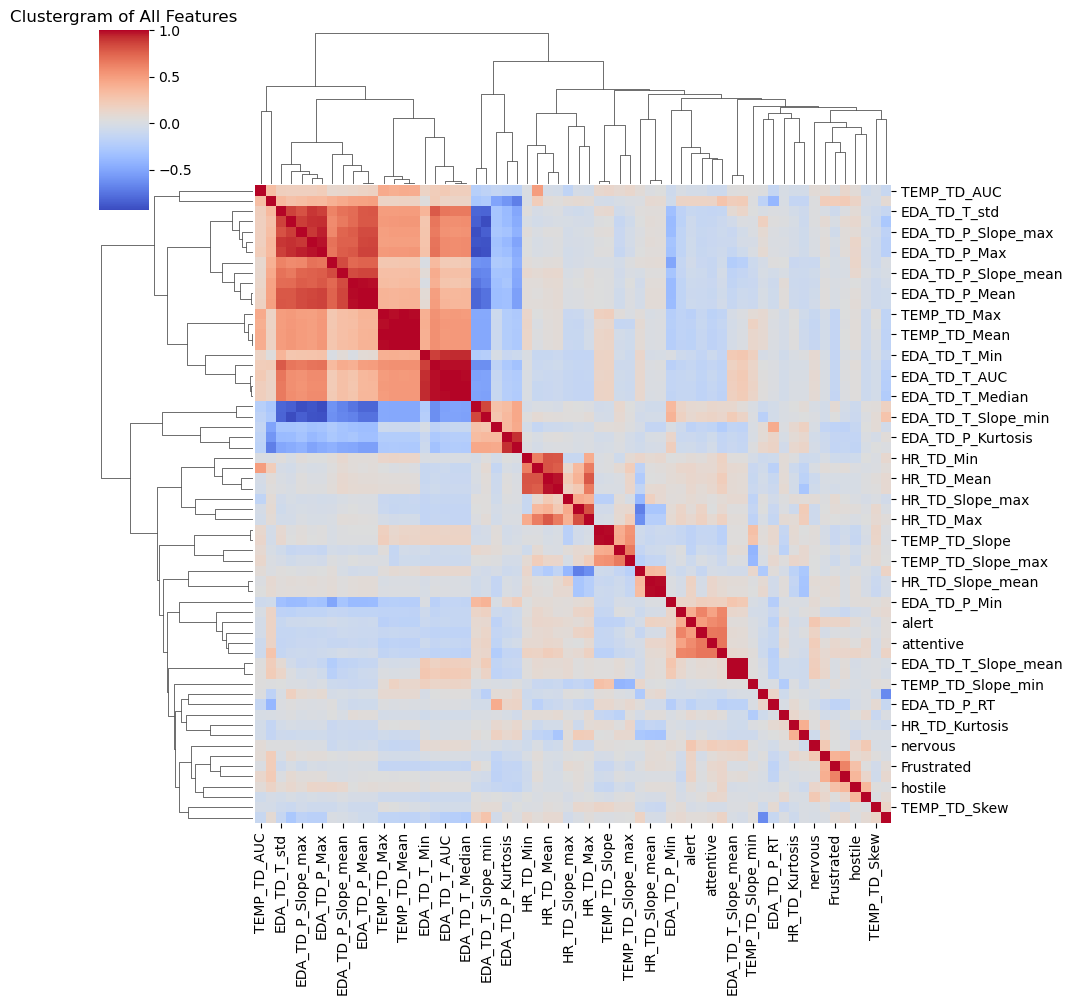

In [49]:
# Making a clustergram (heatmap + dendrogram) of the bio-signals
plt.figure(figsize=(10, 8))
sns.clustermap(X_all.corr(), cmap='coolwarm')
plt.title('Clustergram of All Features')
plt.show()

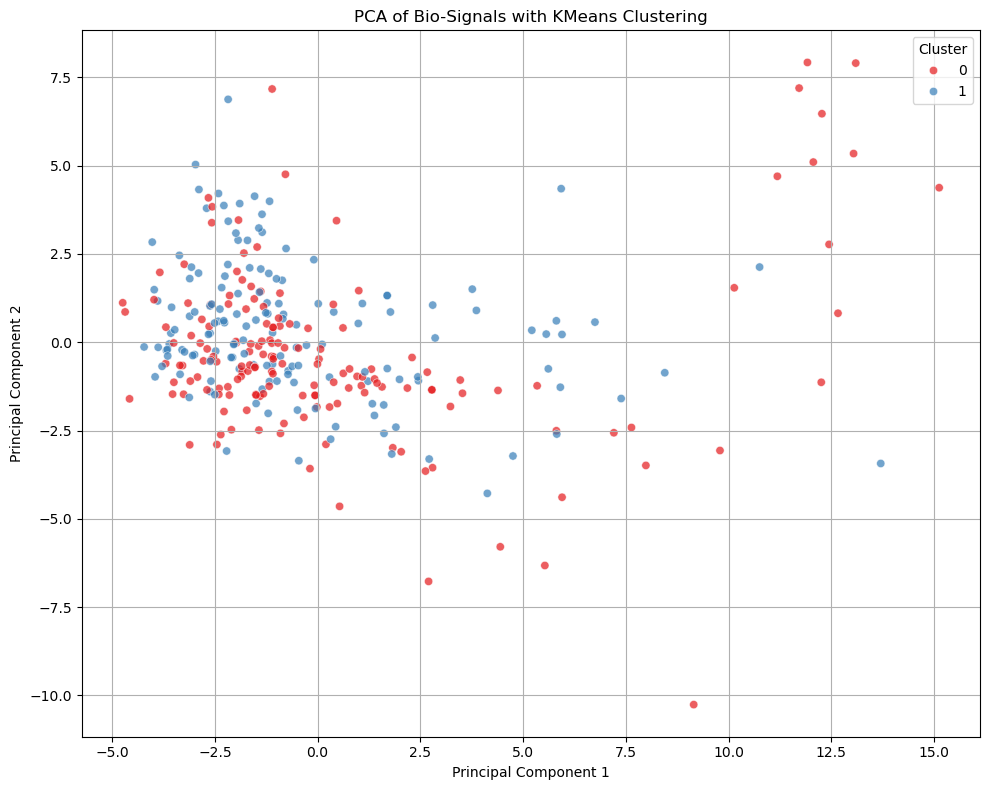

In [73]:
# Fit PCA to standardized data
pca = PCA()
bio_signals_pca = pca.fit_transform(bio_signals_scaled)

# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(bio_signals_pca.shape[1])]
df_pca = pd.DataFrame(bio_signals_pca, columns=pc_cols)

# Running k-means clustering on the EMO signals
# Running k-means clustering on the EMO PCA results
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(emo_signals_pca)

# Adding the cluster labels to the PCA DataFrame
df_pca['Cluster'] = kmeans.labels_

# Showing clusters from EMO signals on a Bio-Signals PCA plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA of Bio-Signals with KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

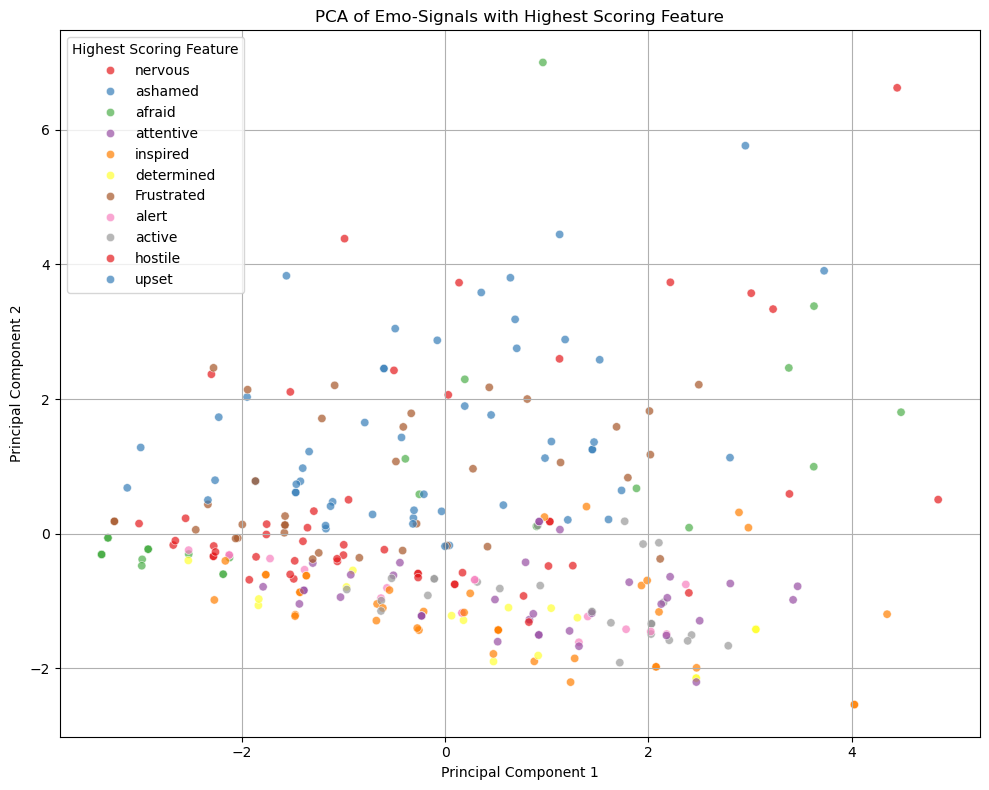

In [75]:
# Create DataFrame for plotting
pc_cols = [f'PC{i+1}' for i in range(emo_signals_pca.shape[1])]
df_pca = pd.DataFrame(emo_signals_pca, columns=pc_cols)

# Divide Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined 
# such that the top scoring feature gets assigned to the corresponding data point
# Find the highest scoring feature for each data point
highest_scoring_feature = np.argmax(self_rated_scaled, axis=1)
# Create a new column in the DataFrame to store the highest scoring feature
df_pca['Highest_Scoring_Feature'] = highest_scoring_feature
# Map the highest scoring feature to the corresponding feature name
feature_names = self_rated.columns.tolist()
df_pca['Highest_Scoring_Feature'] = df_pca['Highest_Scoring_Feature'].map(lambda x: feature_names[x])
# Plotting the PCA results with highest scoring feature
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Highest_Scoring_Feature', palette='Set1', alpha=0.7)
plt.title('PCA of Emo-Signals with Highest Scoring Feature')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Highest Scoring Feature')
plt.tight_layout()
plt.show()